YOU NEED TO FIGURE OUT WHAT THE HELL THIS DOES!!!

In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML


sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST
from Modules import WaveformTools as WFT

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

In [2]:
nh = 256
refRatio = 2
c = 1.
CFL = 0.5
nt = 1
RK = 4
deriv = 'CD'
order = 1
mu = 0.5
sigma = .3
wavenumber = 7
print(wavenumber)

7


In [3]:
omega = BT.Grid(nh)
A = GTT.MakeFullWeight(nh)
print(A)

[[0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

In [4]:
def ConvergTest1(omega, deriv, order):
    # Write in error trap for wavenumber and nh_max.
    nh_max = omega.nh_max
    iters = int(np.log(nh_max) / np.log(2))
    wave = WT.MakeWaves(omega)
    testWave = 2 * np.pi * wave[:, 2]
    waves = wave[:, 1]
    DerivOp = 2 * OT.SpaceDeriv(omega, order, deriv)
    CoarseOp = GTT.MakeFullWeight(nh_max)
    exactDerivOp = TT.ExactSpatOp(omega) # , 0, waves, -1, order)
    exactDeriv = waves @ exactDerivOp
    nhs = 2 ** (np.arange(iters) + 1)
    print(iters)
    NormVec = []#[[] for i in range()]
    for i in range(iters):
        print(i)
        nh = int(nh_max / (2 ** i))
        DerivOp = 0.5 * DerivOp[:nh, :nh]
        DerivOp[0, nh - 1] = DerivOp[1, 0]
        DerivOp[nh - 1, 0] = DerivOp[0, 1]
        if (i > 0):
            CoarseOp = CoarseOp[:nh, :int(2 * nh)]
            waves = CoarseOp @ waves
            testWave = CoarseOp @ testWave
            exactDeriv = CoarseOp @ exactDeriv
        testDeriv = DerivOp @ waves#[:, :nh]
        errorVec = abs(testDeriv - exactDeriv)#[:, :nh])
        NormVec.append(TT.VectorNorm(errorVec))
        print('test and exact:')
        print(testDeriv)
        print(exactDeriv)
        print(testWave)
        print(errorVec)
        print(errorVec ** 2)
        print(sum(errorVec ** 2))
        print(np.sqrt(sum(errorVec ** 2)))
        print('')
        print(NormVec[i])
    NormVec = np.asarray(NormVec)[::-1].transpose()
    print('NormVec is')
    print(NormVec)
    return nhs, NormVec

In [5]:
def ConvergTest(omega, deriv, order):
    # Write in error trap for wavenumber and nh_max.
    nh_max = omega.nh_max
    iters = int(np.log(nh_max) / np.log(2))
    waves = WT.MakeWaves(omega)
#     testWave = 2 * np.pi * wave[:, 2]
#     waves = wave[:, 1]
    DerivOp = 2 * OT.SpaceDeriv(omega, order, deriv)
    CoarseOp = GTT.MakeFullWeight(nh_max)
    exactDerivOp = TT.ExactSpatOp(omega) #, 0, waves, -1, order)
    exactDeriv = waves @ exactDerivOp
    nhs = 2 ** (np.arange(iters) + 1)
    print(iters)
    NormVecs = np.zeros((iters, nh_max), float)#[[] for i in range()]
    mask = np.zeros(nh_max, int)
    masks = []
    for i in range(iters):
        print(i)
        nh = int(nh_max / (2 ** i))
        
        mask[:nh] = 1
        masks.append(list(mask))
        # mask = list(mask)
        print('mask:')
        print(mask)
        print(masks)
        DerivOp = 0.5 * DerivOp[:nh, :nh]
        DerivOp[0, nh - 1] = DerivOp[1, 0]
        DerivOp[nh - 1, 0] = DerivOp[0, 1]
        if (i > 0):
            CoarseOp = CoarseOp[:nh, :int(2 * nh)]
            waves = CoarseOp @ waves
#             testWave = CoarseOp @ testWave
            exactDeriv = CoarseOp @ exactDeriv
        testDeriv = DerivOp @ waves#[:, :nh]
        errorVec = abs(testDeriv - exactDeriv)#[:, :nh])
        NormVec = TT.VectorNorm(errorVec)
        
        #NormVec = ma.masked_array(NormVec, mask = mask)
        
        NormVecs[i, :] = NormVec
        print('Before Mask:')
        print(NormVecs[i, :])
        
        print('After Mask:')
        print(NormVecs[i, :])
        #print(NormVecs[::-1])
        print('test and exact:')
        print(testDeriv)
        print(exactDeriv)
#         print(testWave)
        print(errorVec)
        print(errorVec ** 2)
        print(sum(errorVec ** 2, axis = 0))
        print(np.sqrt(sum(errorVec ** 2, axis = 0)))
        print('')
        print(NormVecs[i])
    masks = [item for sublist in masks for item in sublist]
    print(masks)
    print(NormVecs)
    NormVecs = np.asarray(NormVecs)[::-1]#.transpose()
    ma.masked_array(NormVecs, mask = list(masks))
    print('NormVecs is')
    print(NormVecs)
    return nhs, NormVecs

In [6]:
nhs1, NormVec1 = ConvergTest1(omega, deriv, order)
print(nhs1)


[[   0.   -0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   

In [7]:
nhs, NormVec = ConvergTest(omega, deriv, order)
print(nhs)


[[   0.   -0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   

[[ 0.00000000e+00  6.28192376e+00 -7.70946730e-02  1.25562807e+01 -3.08239389e-01  1.88155160e+01 -6.93016492e-01  2.50520994e+01 -1.23073072e+00  3.12585368e+01 -1.92041049e+00  3.74273825e+01 -2.76080959e+00  4.35512512e+01 -3.75040952e+00  4.96228298e+01 -4.88742214e+00  5.56348888e+01 -6.16979298e+00  6.15802944e+01 -7.59520489e+00  6.74520194e+01 -9.16108226e+00  7.32431545e+01 -1.08645956e+01  7.89469194e+01 -1.27026669e+01  8.45566733e+01 -1.46719746e+01  9.00659258e+01 -1.67689604e+01  9.54683465e+01 -1.89898348e+01  1.00757775e+02 -2.13305847e+01  1.05928233e+02 -2.37869801e+01  1.10973927e+02 -2.63545819e+01  1.15889265e+02 -2.90287498e+01  1.20668862e+02 -3.18046510e+01  1.25307546e+02 -3.46772683e+01  1.29800369e+02 -3.76414094e+01  1.34142612e+02 -4.06917164e+01  1.38329794e+02 -4.38226751e+01  1.42357680e+02 -4.70286250e+01  1.46222280e+02 -5.03037693e+01  1.49919866e+02 -5.36421857e+01  1.53446965e+02 -5.70378363e+01  1.56800375e+02 -6.04845790e+01  1.59977160e+02 -6.397

[[ 0.00000000e+00  6.28255450e+00 -7.71024138e-02  1.25613246e+01 -3.08363211e-01  1.88325283e+01 -6.93643090e-01  2.50923879e+01 -1.23270997e+00  3.13371329e+01 -1.92523914e+00  3.75630015e+01 -2.77081345e+00  4.37662435e+01 -3.76892355e+00  4.99431224e+01 -4.91896822e+00  5.60899175e+01 -6.22025471e+00  6.22029261e+01 -7.67199918e+00  6.82784659e+01 -9.27332716e+00  7.43128774e+01 -1.10232741e+01  8.03025255e+01 -1.29207858e+01  8.62438025e+01 -1.49647193e+01  9.21331294e+01 -1.71538435e+01  9.79669587e+01 -1.94868397e+01  1.03741776e+02 -2.19623025e+01  1.09454104e+02 -2.45787410e+01  1.15100500e+02 -2.73345789e+01  1.20677565e+02 -3.02281563e+01  1.26181937e+02 -3.32577303e+01  1.31610303e+02 -3.64214758e+01  1.36959391e+02 -3.97174873e+01  1.42225980e+02 -4.31437793e+01  1.47406897e+02 -4.66982878e+01  1.52499022e+02 -5.03788719e+01  1.57499287e+02 -5.41833145e+01  1.62404681e+02 -5.81093239e+01  1.67212248e+02 -6.21545353e+01  1.71919092e+02 -6.63165119e+01  1.76522379e+02 -7.059

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[[0.00000000e+00 6.36038398e-06 3.83298906e-09 4.05791066e-04 9.79355381e-07 4.59812586e-03 2.50192827e-05 2.56468500e-02 2.48788718e-04 9.69175447e-02 1.47434075e-03 2.86076775e-01 6.29470898e-03 7.11601189e-01 2.14248615e-02 1.56076569e+00 6.17534582e-02 3.10794214e+00 1.56721323e-01 5.73195214e+00 3.59643985e-01 9.93118433e+00 7.60565021e-01 1.63352093e+01 1.50315306e+00 2.57117063e+01 2.80603872e+00 3.89676517e+01 4.98883104e+00 5.71439053e+01 8.50286038e+00 8.14025673e+01 1.39664725e+01 1.13006746e+02 2.22044538e+01 1.53292678e+02 3.42909098e+01 2.03634471e+02 5.15946571e+01 2.65402041e+02 7.58259349e+01 3.39913171e+02 1.09083005e+02 4.28380900e+02 1.53896999e+02 5.31857725e+02 2.13273202e+02 6.51178366e+02 2.90726846e+02 7.86902984e+02 3.90311402e+02 9.39262922e+02 5.16637374e+02 1.10811106e+03 6.74879657e+02 1.29287892e+03 8.70771639e+02 1.49254250e+03 1.11058445e+03 1.70559876e+03 1.40109001e+03 1.93005442e+03 1.74950690e+03 2.16342839e+03 2.16342839e+03 2.40276896e+03 2.650732

[[ 0.00000000e+00  6.27309698e+00 -3.08177493e-01  1.24857806e+01 -1.22974205e+00  1.85782193e+01 -2.75581851e+00  2.44917397e+01 -4.87170992e+00  3.01693912e+01 -7.55703908e+00  3.55564949e+01 -1.07859448e+01  4.06011702e+01 -1.45273310e+01  4.52548340e+01 -1.87451660e+01  4.94726690e+01 -2.33988298e+01  5.32140552e+01 -2.84435051e+01  5.64429609e+01 -3.38306088e+01  5.91282901e+01 -3.95082603e+01  6.12441815e+01 -4.54217807e+01  6.27702579e+01 -5.15142194e+01  6.36918225e+01 -5.77269030e+01  6.40000000e+01 -6.40000000e+01  6.36918225e+01 -7.02730970e+01  6.27702579e+01 -7.64857806e+01  6.12441815e+01 -8.25782193e+01  5.91282901e+01 -8.84917397e+01  5.64429609e+01 -9.41693912e+01  5.32140552e+01 -9.95564949e+01  4.94726690e+01 -1.04601170e+02  4.52548340e+01 -1.09254834e+02  4.06011702e+01 -1.13472669e+02  3.55564949e+01 -1.17214055e+02  3.01693912e+01 -1.20442961e+02  2.44917397e+01 -1.23128290e+02  1.85782193e+01 -1.25244181e+02  1.24857806e+01 -1.26770258e+02  6.27309698e+00 -1.276

[[0.00000000e+00 1.01447766e-04 2.44838845e-07 6.41171249e-03 6.21971795e-05 7.15191939e-02 1.57367725e-03 3.90191423e-01 1.54383645e-02 1.43298804e+00 8.99109961e-02 4.08380232e+00 3.75788265e-01 9.74191292e+00 1.24720776e+00 2.03506418e+01 3.49161813e+00 3.83231696e+01 8.57272745e+00 6.63505103e+01 1.89564837e+01 1.07095225e+02 3.84742496e+01 1.62794592e+02 7.26817116e+01 2.34815730e+02 1.29159344e+02 3.23219731e+02 2.17692910e+02 4.26399690e+02 3.50272503e+02 5.40857098e+02 5.40857098e+02 6.61171560e+02 8.04868627e+02 7.80201003e+02 1.15840410e+03 8.89524871e+02 1.61718407e+03 9.80114165e+02 2.19528794e+03 1.04318269e+03 2.90375733e+03 1.07114723e+03 3.74917449e+03 1.05860404e+03 4.73234014e+03 1.00321771e+03 5.84718131e+03 9.06418177e+02 7.08001283e+03 7.73813200e+02 8.40925711e+03 6.15245727e+02 9.80569457e+03 4.44457296e+02 1.12332770e+04 2.78355850e+02 1.26504886e+04 1.35926066e+02 1.40121925e+04 3.68578171e+01 1.52718545e+04 5.04870979e-29 1.63840000e+04 4.17688904e+01 1.730673

[[0.00000000e+00 4.00365848e-02 3.94325942e-03 3.12326521e-01 6.21256077e-02 1.01042099e+00 3.06507857e-01 2.25558428e+00 9.34293601e-01 4.07279113e+00 2.17695221e+00 6.37954919e+00 4.26267849e+00 8.98915640e+00 7.37721001e+00 1.16281673e+01 1.16281673e+01 1.39660392e+01 1.70176680e+01 1.56533875e+01 2.34269500e+01 1.63641928e+01 3.06152515e+01 1.58368061e+01 3.82334321e+01 1.39087490e+01 4.58510008e+01 1.05410779e+01 5.29935774e+01 5.82936672e+00 5.91865536e+01 3.55271368e-15 6.40000000e+01 6.60776405e+00 6.70897543e+01 1.35718191e+01 6.82301421e+01 2.04257990e+01 6.73348354e+01 2.67017835e+01 6.44638080e+01 3.19723220e+01 5.98160073e+01 3.58872166e+01 5.37090152e+01 3.82012945e+01 4.65484121e+01 3.87906109e+01 3.87906109e+01 3.76560013e+01 3.09034816e+01 3.49144364e+01 2.33290806e+01 3.07800343e+01 1.64522711e+01 2.55376788e+01 1.05780529e+01 1.95128502e+01 5.91915839e+00 1.30414394e+01 2.59410358e+00 6.44298236e+00 6.34578374e-01 3.55271368e-15 1.82076576e-14 6.05492504e+00 5.963580

[[0.00000000e+00 1.56163261e-01 3.10628039e-02 1.12779214e+00 4.67146800e-01 3.18977460e+00 2.13133924e+00 5.81408364e+00 5.81408364e+00 7.82669377e+00 1.17134750e+01 7.91840305e+00 1.91167160e+01 5.27053897e+00 2.64967887e+01 1.77635684e-15 3.20000000e+01 6.78590955e+00 3.41150711e+01 1.33508918e+01 3.22319040e+01 1.79436083e+01 2.68545076e+01 1.93953055e+01 1.93953055e+01 1.74572182e+01 1.16645403e+01 1.27688394e+01 5.28902646e+00 6.52071969e+00 1.29705179e+00 1.33226763e-15 8.88178420e-15 5.77194835e+00 1.14811191e+00 1.01819400e+01 4.21749765e+00 1.29517097e+01 8.65405574e+00 1.39628167e+01 1.39628167e+01 1.31260300e+01 1.96444921e+01 1.03877161e+01 2.50781651e+01 5.86351006e+00 2.94778557e+01 7.10542736e-15 3.20000000e+01 6.36160578e+00 3.19819520e+01 1.20972405e+01 2.92053221e+01 1.60701056e+01 2.40506127e+01 1.74551309e+01 1.74551309e+01 1.59812758e+01 1.06783471e+01 1.19927696e+01 4.96756781e+00 6.31541142e+00 1.25621344e+00 7.10542736e-15 8.88178420e-15 5.94212366e+00 1.181961

 [ 0.00000000e+00 -4.44089210e-16  4.00000000e+00 -6.66133815e-16  0.00000000e+00 -2.22044605e-15  4.00000000e+00 -6.66133815e-16  0.00000000e+00 -3.55271368e-15  4.00000000e+00 -1.33226763e-15 -4.44089210e-16 -4.66293670e-15  4.00000000e+00 -2.22044605e-15  0.00000000e+00 -7.32747196e-15  4.00000000e+00 -1.77635684e-15  0.00000000e+00 -2.90878432e-14  4.00000000e+00 -3.33066907e-15 -8.88178420e-16  1.11022302e-14  4.00000000e+00 -2.88657986e-15 -4.44089210e-16 -3.08642001e-14  4.00000000e+00 -3.77475828e-15  0.00000000e+00  9.32587341e-15  4.00000000e+00 -2.22044605e-15 -8.88178420e-16 -3.41948692e-14  4.00000000e+00 -4.44089210e-15 -4.44089210e-16  5.32907052e-15  4.00000000e+00 -2.08721929e-14 -8.88178420e-16 -3.88578059e-14  4.00000000e+00 -6.21724894e-15  8.88178420e-16  2.66453526e-15  4.00000000e+00  9.32587341e-15  0.00000000e+00 -4.13002965e-14  4.00000000e+00 -7.99360578e-15  8.88178420e-16 -2.22044605e-16  4.00000000e+00 -2.24265051e-14  8.88178420e-16 -4.41868764e-14  4.000

[2.26088069e+00 1.66765728e+01 2.42971670e+01 3.44395156e+01 4.87188422e+01 6.89152778e+01 9.75163899e+01 5.15141033e+03]



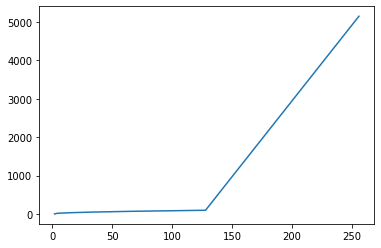

In [8]:
plt.figure()
plt.plot(nhs1, NormVec1)
print(NormVec1)
print('')
plt.show()

[0.90031632 2.90704182 1.22071342 0.45034975 0.16092122 0.05704527 0.02018192 0.00713657]



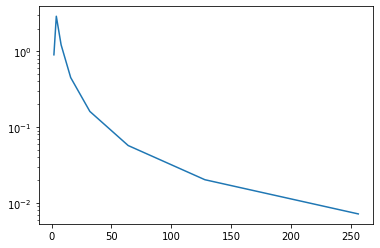

In [9]:
plt.figure()
plt.plot(nhs, NormVec[:, 1])
print(NormVec[:, 1])
print('')
plt.yscale('log')
plt.show()

In [10]:
print('32:', [0.16092122, 0.45034975, 1.22071342, 2.90704182, 0.90031632])
print('512:', [2.52326242e-03, 7.13656831e-03, 2.01819198e-02, 5.70452747e-02, 1.60921219e-01, 4.50349746e-01, 1.22071342e+00, 2.90704182e+00, 9.00316316e-01])

32: [0.16092122, 0.45034975, 1.22071342, 2.90704182, 0.90031632]
512: [0.00252326242, 0.00713656831, 0.0201819198, 0.0570452747, 0.160921219, 0.450349746, 1.22071342, 2.90704182, 0.900316316]


In [11]:
A = np.arange(16).reshape(4, 4)
print(A)
print(A ** 2)
print('')
print(sum(A, axis = 0))
out = TT.VectorNorm(A)
print(out)
print(A[:, :2])
A = ma.masked_array(A, mask=[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])
print(A)
print(type([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]))
C = np.ones(6, float)
print(type(C))
C = list(C)
print(type(C))

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
[[  0   1   4   9]
 [ 16  25  36  49]
 [ 64  81 100 121]
 [144 169 196 225]]

[24 28 32 36]
[14.96662955 16.61324773 18.33030278 20.09975124]
[[ 0  1]
 [ 4  5]
 [ 8  9]
 [12 13]]
[[0 1 2 --]
 [4 5 6 --]
 [8 9 10 11]
 [12 13 14 --]]
<class 'list'>
<class 'numpy.ndarray'>
<class 'list'>
